In [1]:
dataset <- "TAA"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Trentino-Alto Adige"
match_dist <- 10000
new_dataset <- "TAA2"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = 5000) |>
    st_drop_geometry() |>
    filter(is.na(state) | !(state %in% c("Veneto", "Lombardia"))) |>
    mutate(
        user_code = if_else(dataset != "SCIA",
            user_code,
            if_else(str_length(user_code) == 4L,
                paste0("T", user_code),
                str_remove(user_code, regex("^21"))
            )
        ),
        user_code = str_to_upper(user_code) |> str_squish()
    )
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    mutate(user_code = str_to_upper(user_code) |> str_squish()) |>
    collect()

metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", "trentino", "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", "trentino", "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/trentino/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", "trentino", "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [6]:
path_from <- prepare_data_for_merge(conns$data)
saved_to <- merge_same_series(path_from, fs::path("db", "tmp"), new_dataset, tagged_analysis, metadata, data, 1, 2L*365L, merging_datasets, desc(dataset), desc(sensor_last), desc(network))
merged_checkpoint(new_dataset, saved_to, metadata)

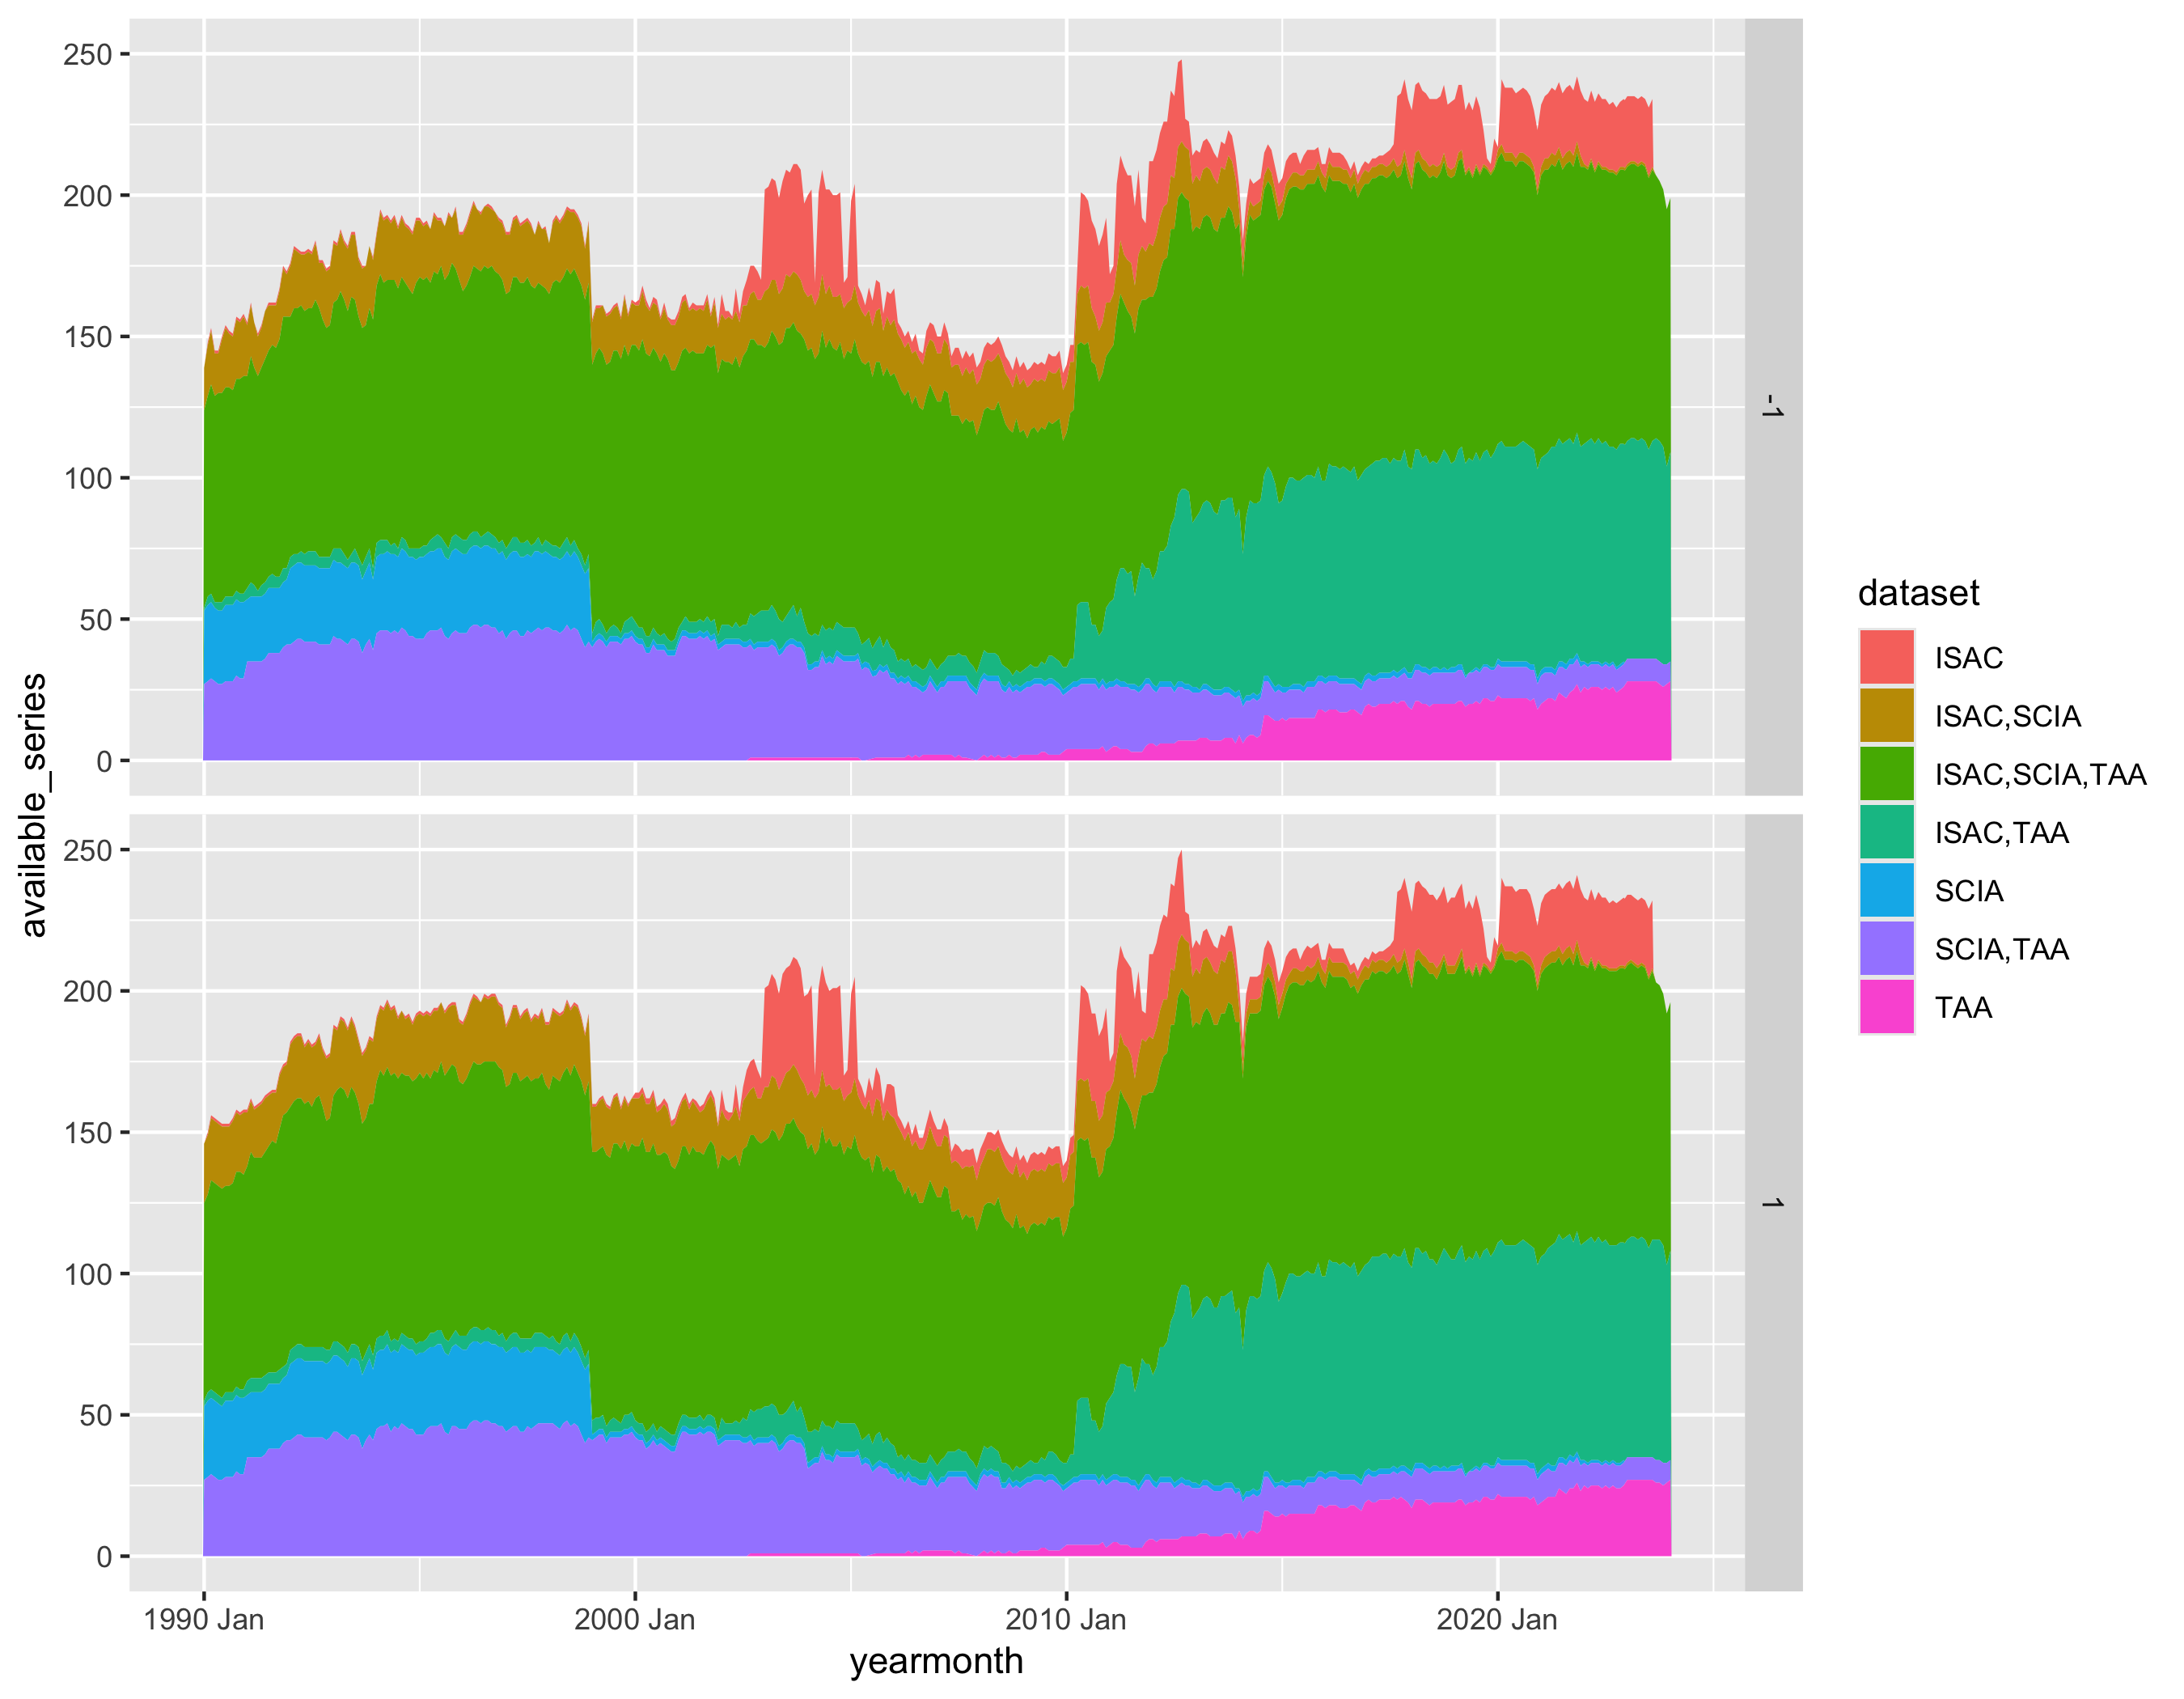

In [7]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


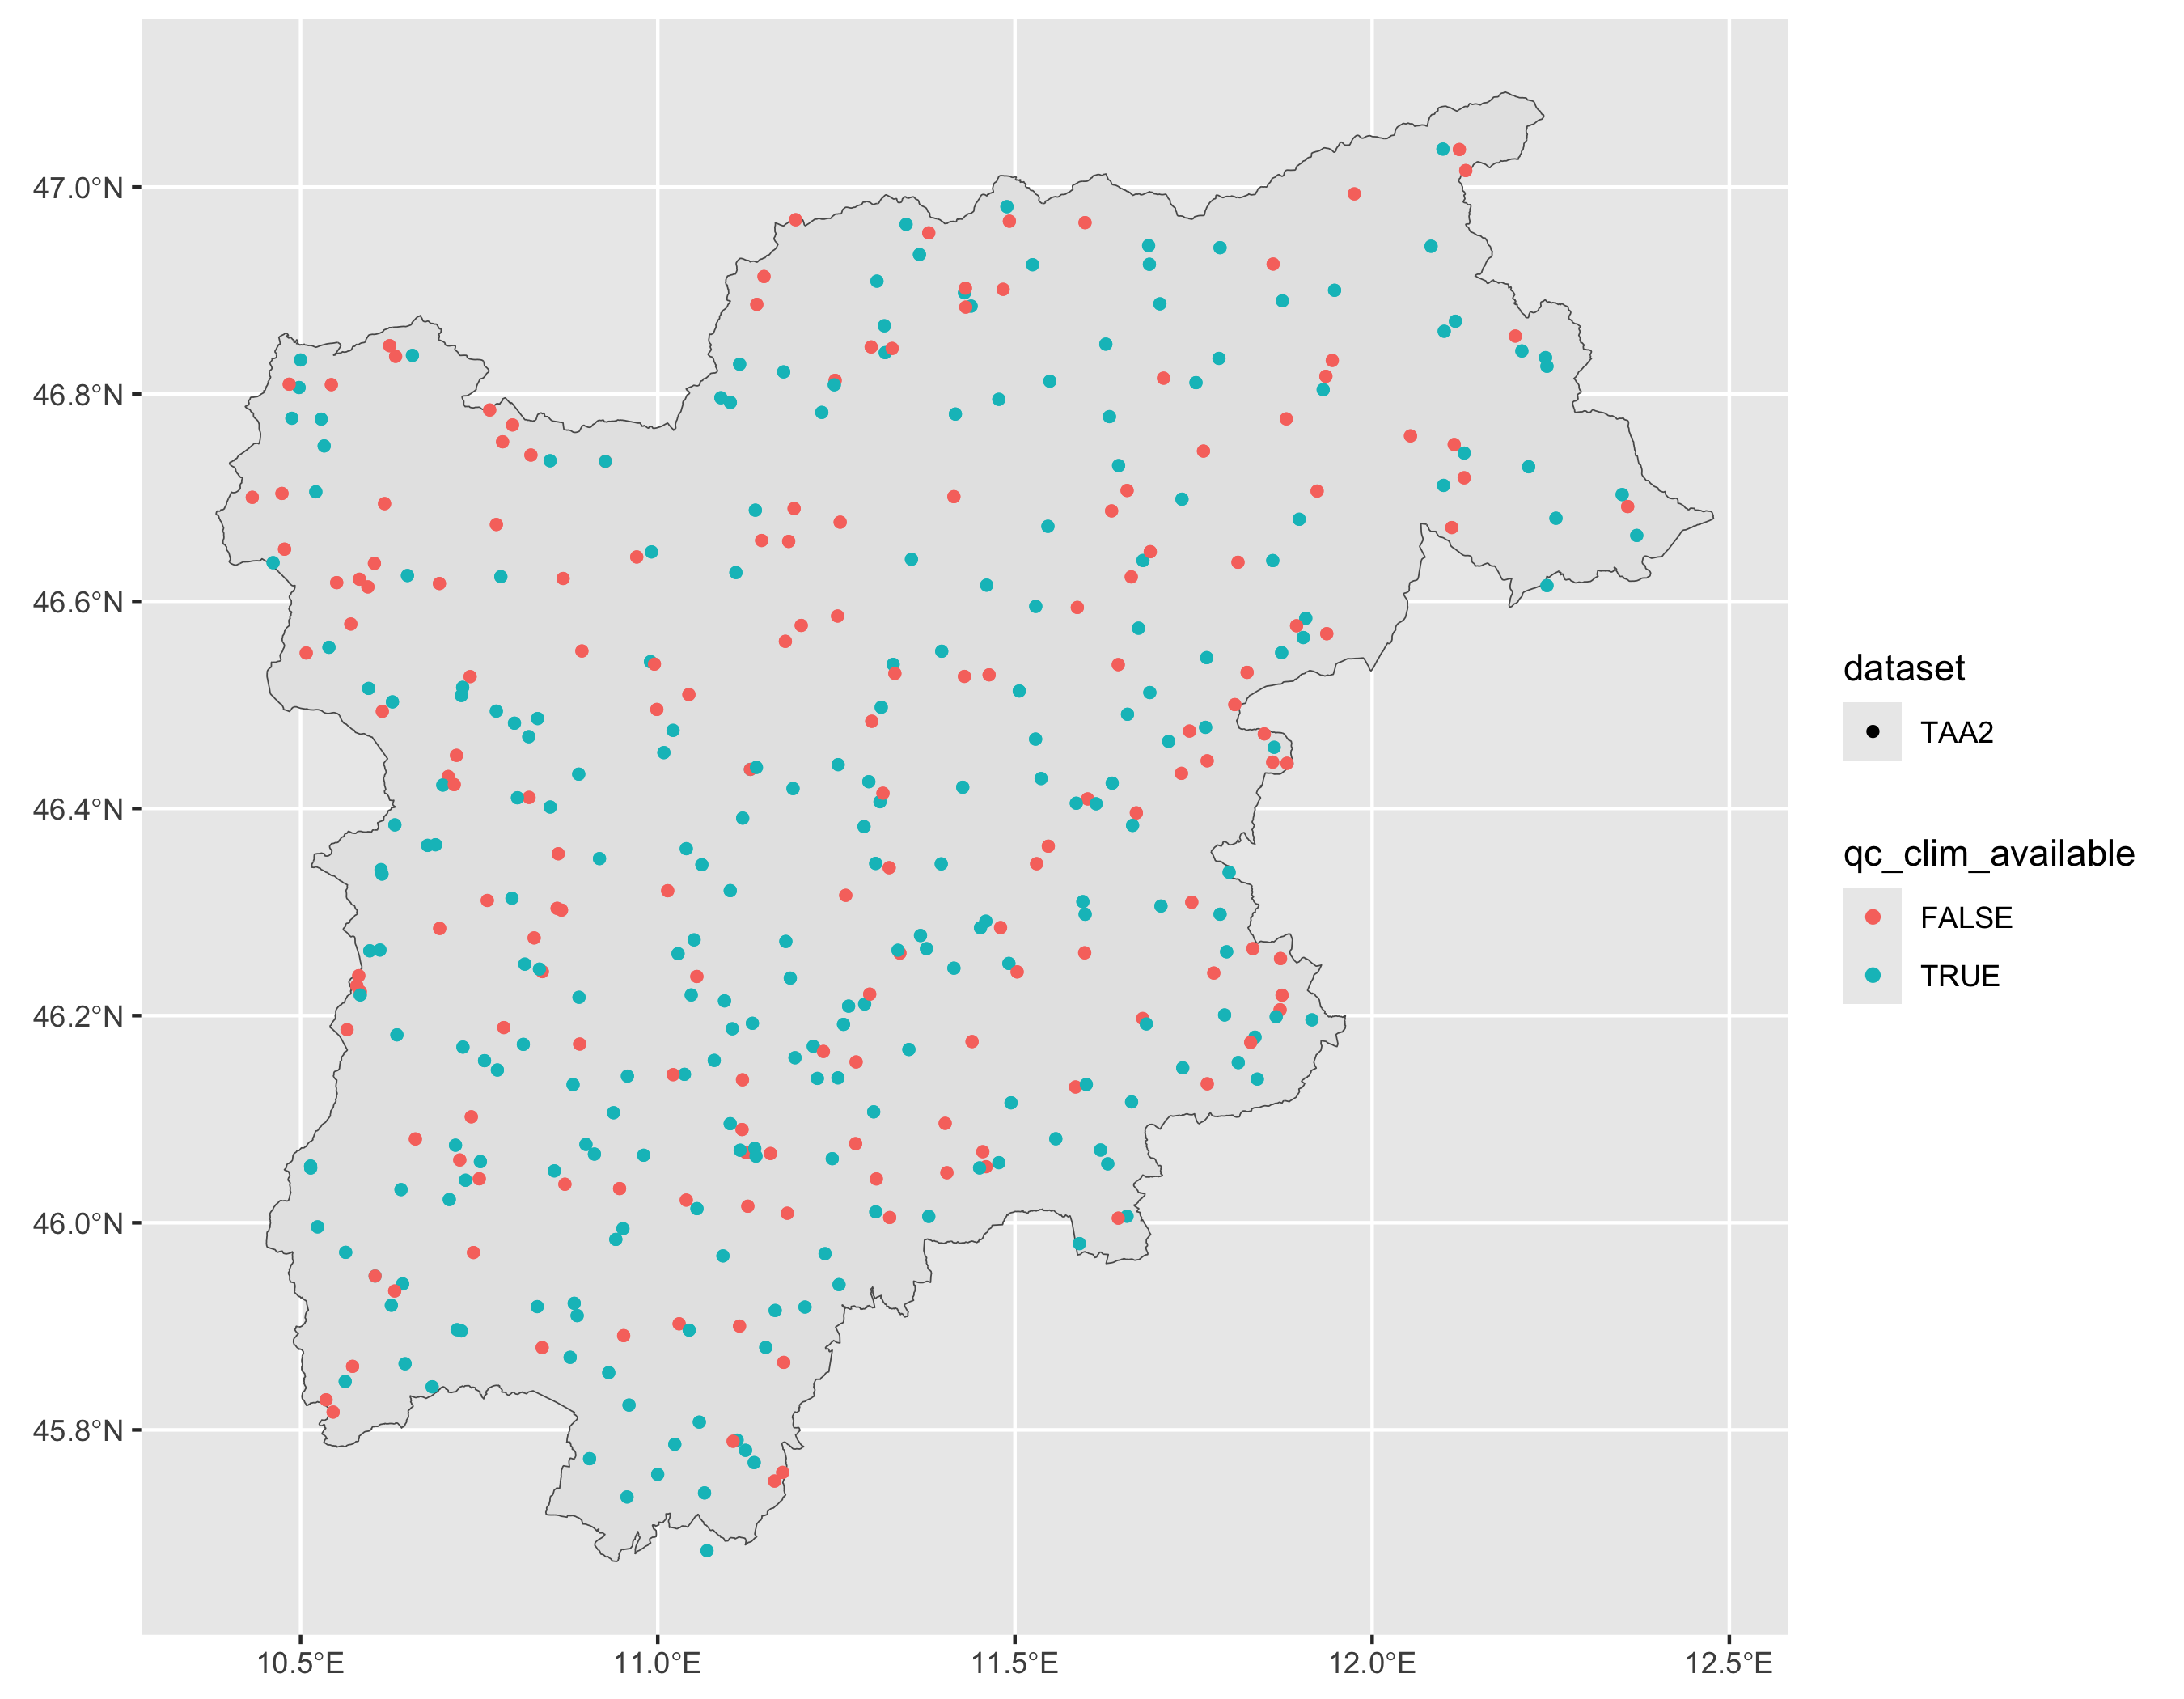

In [8]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 10L)
pd$plot


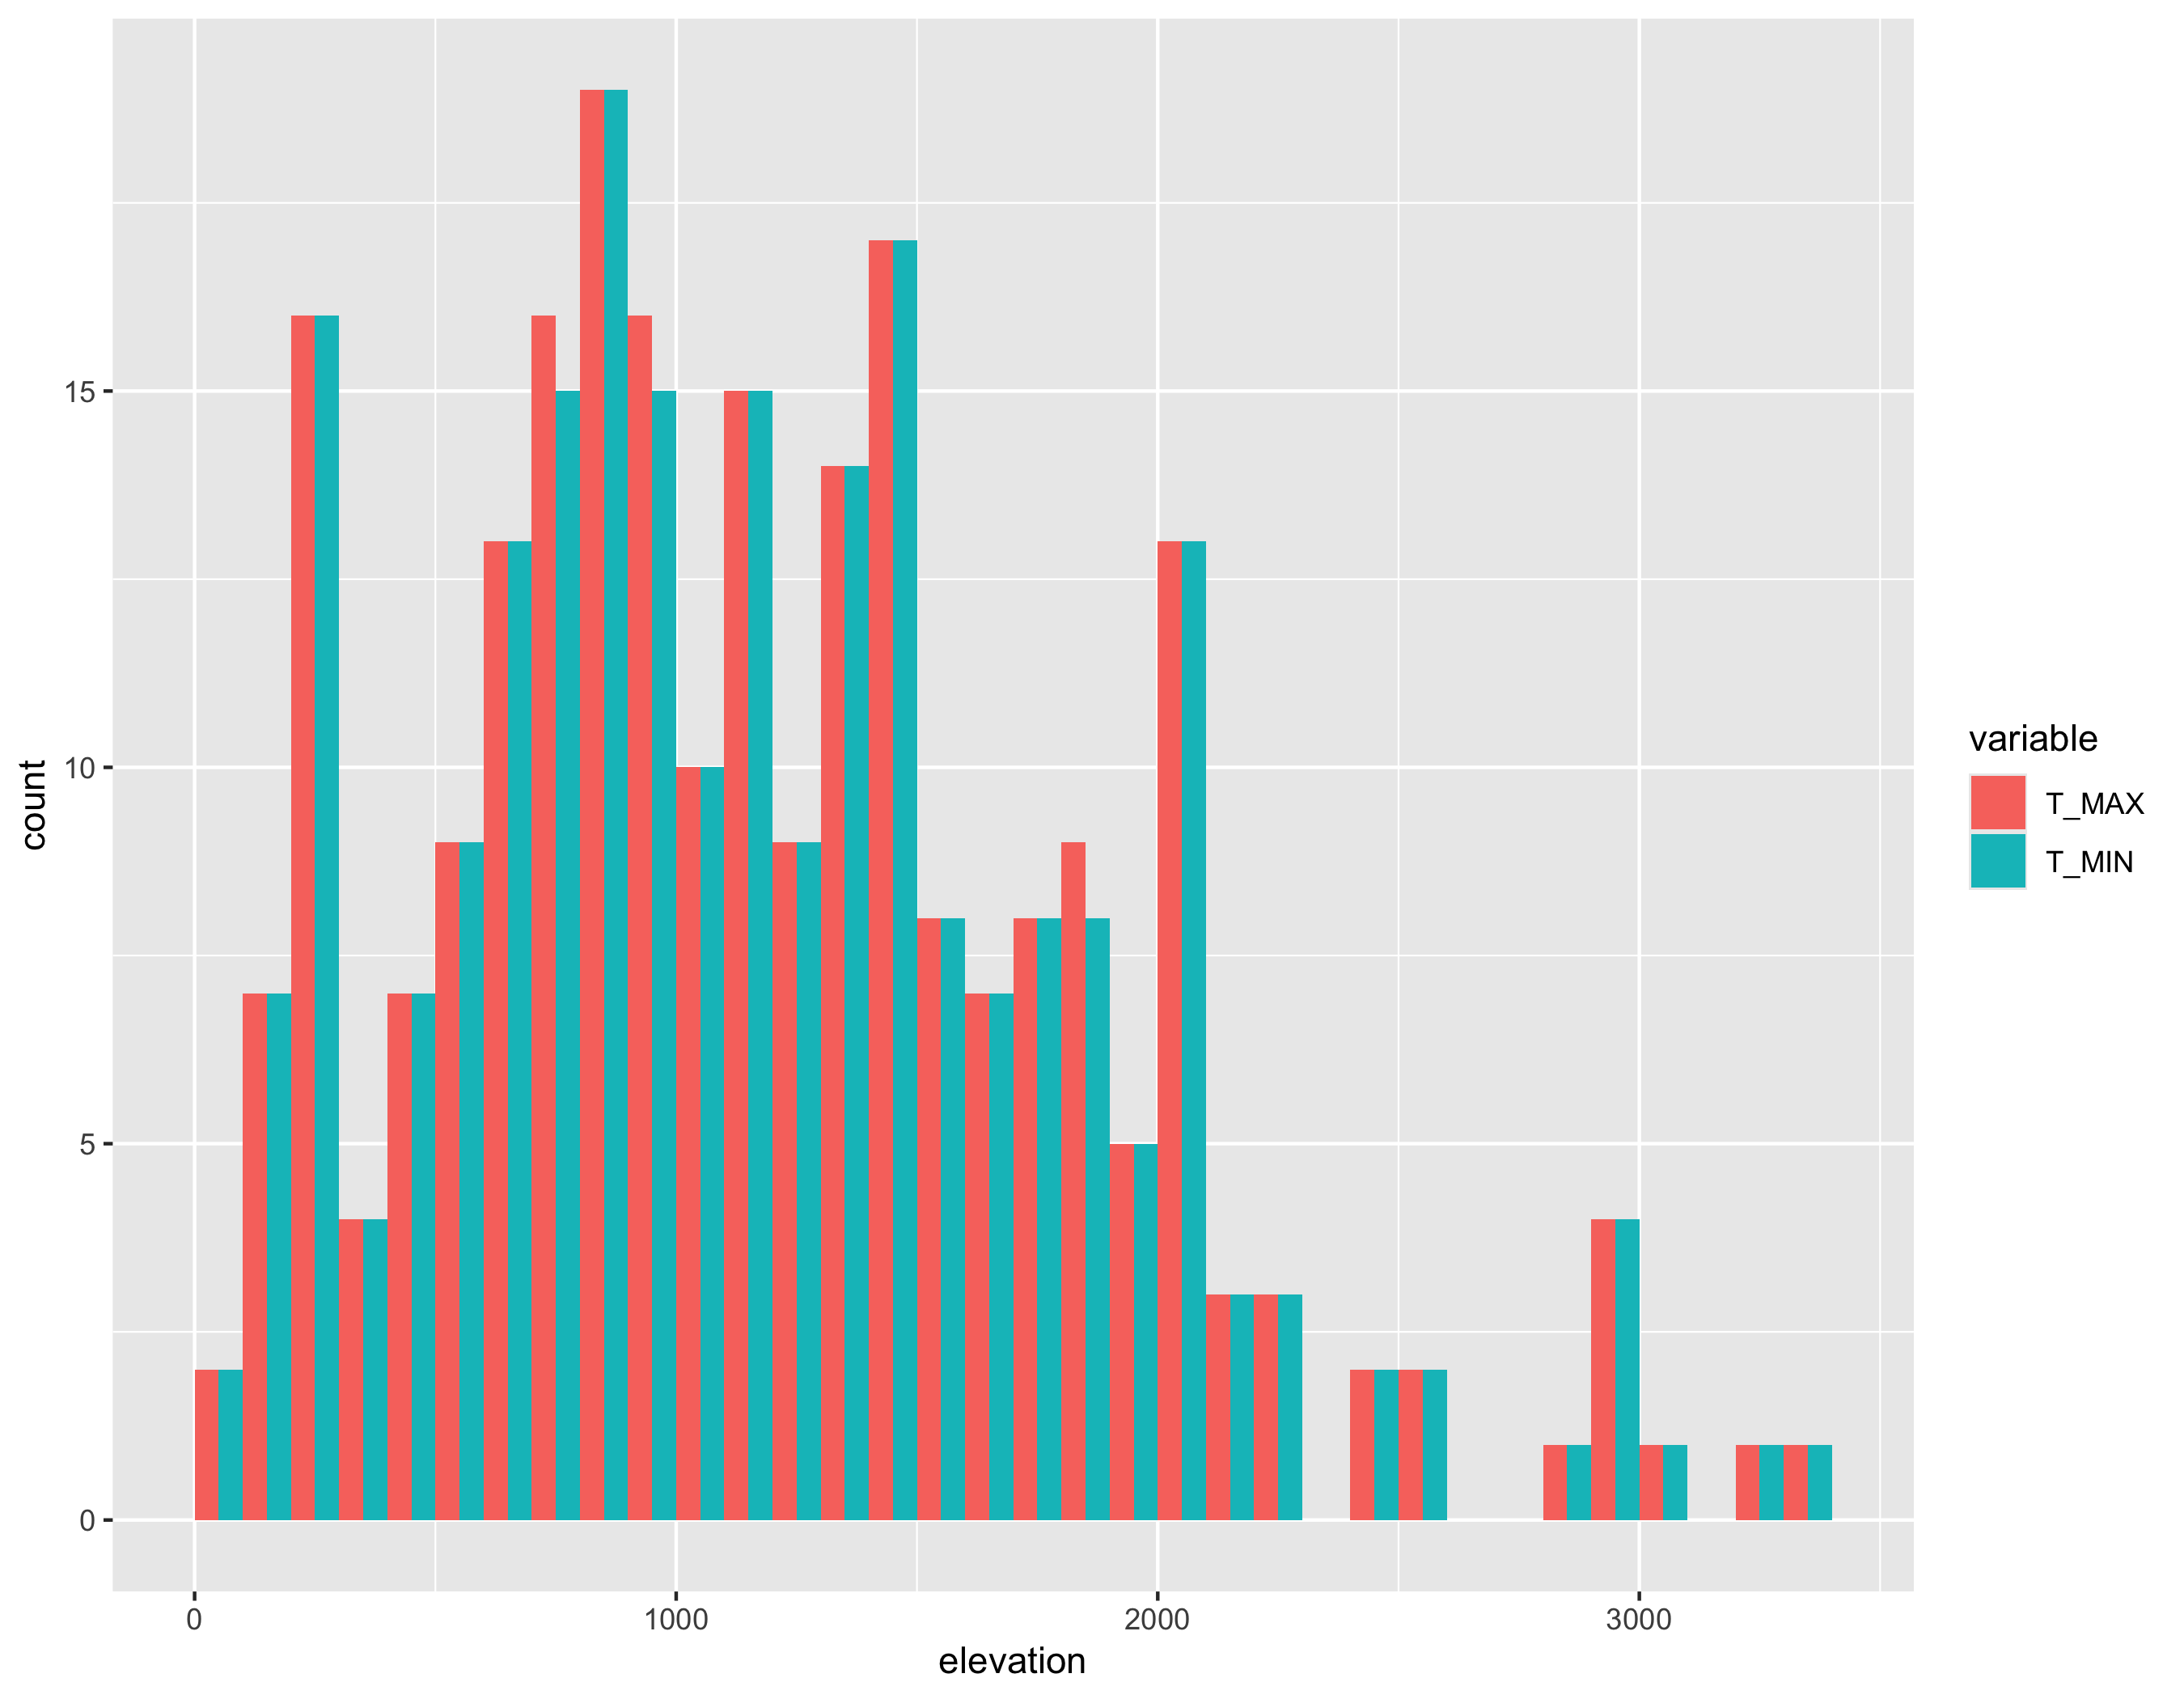

In [9]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [10]:
merge_specs <- read_parquet(str_glue("db/extra/merge_specs/{new_dataset}.parquet")) |>
    mutate(km = k0 + 2 * k1 / pi)
merge_specs |>
    filter(abs(km) > 0.5) |>
    arrange(desc(abs(km))) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    relocate(km, name)

km,name,set,gkey,variable,metadata_rank,data_rank,skip_correction,dataset,sensor_key,force_merge,k0,k1,k2,k3,merged,offset
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
-1.0405505,CAMPO_TURES,TAA2,23,1,4,4,FALSE,ISAC,583,FALSE,-1.5972813,0.874510652,0.072928417,-0.020674675,FALSE,0
0.8960526,RAGOLI_RIFUGIO_ALIMONTA,TAA2,141,1,2,2,FALSE,ISAC,2906,FALSE,0.8960526,0.000000000,0.000000000,0.000000000,FALSE,0
-0.8501725,Groste' Rifugio Graffer,TAA2,99,1,2,2,FALSE,SCIA,1722,FALSE,-0.9551293,0.164865812,-0.228166313,-0.015529635,FALSE,0
0.8168165,MALE,TAA2,81,-1,4,4,FALSE,ISAC,1876,FALSE,0.6280333,0.296540032,0.051946116,0.157398637,FALSE,0
-0.7844793,Arco,TAA2,9,1,2,2,FALSE,SCIA,219,FALSE,-0.6264170,-0.248283798,-0.028399828,-0.025478425,FALSE,0
0.7783620,LASES_FRANA,TAA2,77,1,3,3,FALSE,ISAC,1698,FALSE,0.5350677,0.382165747,0.004826798,0.034594324,FALSE,0
-0.7414079,Somrabbi (Piazzola di Rabbi),TAA2,266,1,2,2,FALSE,SCIA,3859,FALSE,-0.5398238,-0.316647542,-0.035669042,-0.079392144,FALSE,0
-0.7365102,CAMPO_TURES,TAA2,23,-1,4,4,FALSE,ISAC,583,FALSE,-0.9068780,0.267613161,-0.056513397,0.012085750,FALSE,0
-0.7213925,Tremalzo,TAA2,186,1,2,2,FALSE,SCIA,4067,FALSE,-0.7682982,0.073679298,-0.085993580,-0.058684499,FALSE,0


In [13]:
merge_specs |> filter(gkey == 23L) |>
    select(dataset, sensor_key, variable, data_rank, metadata_rank, km, k0, k1) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key"))


dataset,sensor_key,variable,data_rank,metadata_rank,km,k0,k1,name
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
TAA,28,-1,1,1,0.000000000,0.000000000,0.000000000,Campo Tures Molini
SCIA,2368,-1,2,2,-0.008312568,-0.012145113,0.006020147,Molini di Tures
ISAC,584,-1,3,3,-0.232873844,-0.339113594,0.166881010,CAMPO_TURES_MOLINI
ISAC,583,-1,4,4,-0.736510186,-0.906878015,0.267613161,CAMPO_TURES
TAA,28,1,1,1,0.000000000,0.000000000,0.000000000,Campo Tures Molini
SCIA,2368,1,2,2,0.002114645,0.004735358,-0.004116607,Molini di Tures
ISAC,584,1,3,3,0.301447559,0.235286182,0.103926049,CAMPO_TURES_MOLINI
ISAC,583,1,4,4,-1.040550485,-1.597281257,0.874510652,CAMPO_TURES
